# Investigating the benefit of using oversampling with a basic CNN to identify COVID-19 from coughs

Model reads in image files that have been created from cough audio files.
Machine learning is applied to create a classifier. The aim of oversampling is to balance the classes by adding duplicates of the minority class samples.

This Model uses ImageDataGenerator

Mounting the Google Drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Upload images to pandas dataframe and visualize a few images.

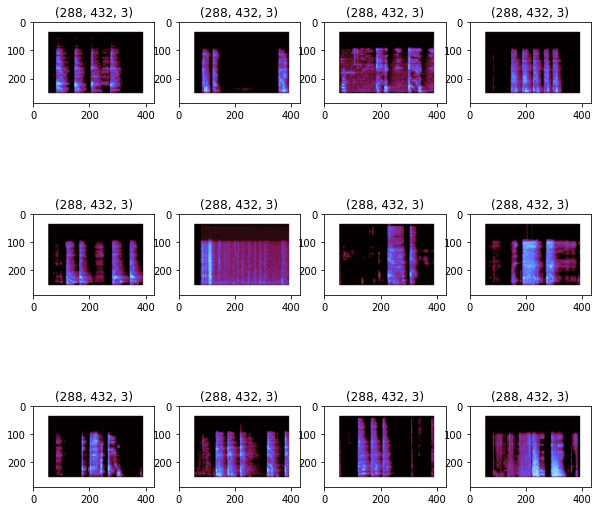

In [2]:
# Always run this code.
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from contextlib import redirect_stdout
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from sklearn.metrics import roc_curve

folder = '/content/drive/My Drive/Colab Notebooks/COVID-19'
if not os.path.exists(folder):
  print(folder + ' does not exist')


df_images = pd.read_csv(os.path.join(folder, 'df_train.csv'), index_col=0)

fnames = df_images.loc[:,'image_file']

plt.figure(figsize=(10,10))
for i in range(12): 
    plt.subplot(3,4,i+1)
    
    filename = fnames[i]
    if not os.path.exists(filename):
      print ('No such file:'+filename)
    
    image = imread(filename)
    plt.title(image.shape)
    plt.imshow(image)
    
plt.show()


In [3]:
pd.set_option('max_columns', None)
print(df_images.shape)
print(df_images.head(5))

(11401, 8)
                                     id   age  gender    status  \
0          Zb2Inq1UVhcMnWA41GpKyRdF4z62  66.0  female   healthy   
1  c4138919-bd2c-4e24-9fcf-582e428c7d27  37.0  female   healthy   
2          ygiPwZYsKFetOejhxWXB6rKSHAf2  66.0    male  COVID-19   
3  ec8ddd1e-d555-490f-9719-70a99c1c6993  29.0    male   healthy   
4          CFkIEzwZ5PcogCElOD2K3RJQzmh1  44.0    male   healthy   

                                          audio_file  \
0  /content/drive/My Drive/Colab Notebooks/coswar...   
1  /content/drive/My Drive/Colab Notebooks/coughv...   
2  /content/drive/My Drive/Colab Notebooks/coswar...   
3  /content/drive/My Drive/Colab Notebooks/coughv...   
4  /content/drive/My Drive/Colab Notebooks/coswar...   

                                          image_file    source  cough_detected  
0  /content/drive/My Drive/Colab Notebooks/coswar...   coswara             NaN  
1  /content/drive/My Drive/Colab Notebooks/coughv...  coughvid          1.0000  
2  /co

## Rearrange the dataset
Split into training set and validation set


In [4]:
# Always run this code.
validation_proportion = 0.3 #Change this if you want to change ratio of validation to training.

num_rows = df_images.shape[0]

df_val = df_images.iloc[:int(validation_proportion*num_rows)]
df_train = df_images.iloc[int(validation_proportion*num_rows):]

print (df_images.shape)
print (df_train.shape)
print (df_val.shape)

print (df_train.head(10))
print (df_val.head(10))

#Check we have a range of images in each set.

print(df_train.groupby('status').status.count())
print(df_val.groupby('status').status.count())

(11401, 8)
(7981, 8)
(3420, 8)
                                        id   age  gender    status  \
3420  6ea0f6b7-8110-4940-b848-0635be9b5978  29.0    male   healthy   
3421          zM5GsorprLYElGQ3uJwnU0g0Fwr1  35.0    male  COVID-19   
3422          bx564wHvi9d0HyJTtdi0haZuU493  28.0    male  COVID-19   
3423  07e2f7e1-8e9b-4962-8701-fbe1224de7ef  28.0    male   healthy   
3424  aeeb58ec-cefc-4d57-b2f5-db03cf502ae4   NaN  female   healthy   
3425  79319102-5fd0-46bd-b091-017b1c0973d1  52.0    male   healthy   
3426  f2d5ad83-91b7-4efe-9bc9-4adf3a08cf7d  30.0    male   healthy   
3427          KFtd9lY6jph5cl2VrZ9Nv8Jng7p1  42.0    male   healthy   
3428  1278ade5-08ec-4993-b5f8-8b8cf522e7be  45.0    male   healthy   
3429          E3nlERKGBPcSO2PjEDJ6GrRKiy73  47.0    male  COVID-19   

                                             audio_file  \
3420  /content/drive/My Drive/Colab Notebooks/coughv...   
3421  /content/drive/My Drive/Colab Notebooks/coswar...   
3422  /content/drive/

# Dealing with Imbalanced Dataset

Adding a copy of all COVID-19 images in training dataset to improve the balance of the data - **oversampling**.

In [5]:
#Create dataframe of just covid images from df_train
df_covid = df_train.loc[df_train.status =='COVID-19']
print(df_covid.shape)
print(df_covid.head())

(832, 8)
                                        id   age  gender    status  \
3421          zM5GsorprLYElGQ3uJwnU0g0Fwr1  35.0    male  COVID-19   
3422          bx564wHvi9d0HyJTtdi0haZuU493  28.0    male  COVID-19   
3429          E3nlERKGBPcSO2PjEDJ6GrRKiy73  47.0    male  COVID-19   
3431  522a43ec-3d80-43e4-97c9-c21ceb8b7a63  28.0  female  COVID-19   
3437          Z8ulmLPAsmhYfYuqUAmm6aGy5r53  32.0    male  COVID-19   

                                             audio_file  \
3421  /content/drive/My Drive/Colab Notebooks/coswar...   
3422  /content/drive/My Drive/Colab Notebooks/coswar...   
3429  /content/drive/My Drive/Colab Notebooks/coswar...   
3431  /content/drive/My Drive/Colab Notebooks/coughv...   
3437  /content/drive/My Drive/Colab Notebooks/coswar...   

                                             image_file    source  \
3421  /content/drive/My Drive/Colab Notebooks/coswar...   coswara   
3422  /content/drive/My Drive/Colab Notebooks/coswar...   coswara   
3429  /c

In [6]:
# Add copies of all COVID-19 images to dataframe df_train
covid = df_train.groupby('status').status.count()[0]
healthy = df_train.groupby('status').status.count()[1]
extra_required = healthy - covid

for i in range (int(extra_required/covid)):
  df_train = pd.concat([df_train,df_covid]) 

new_covid = int(extra_required/covid) * covid + covid

if healthy > new_covid:
  df_train = pd.concat([df_train,df_covid[:(healthy - new_covid)]])

df_train = df_train.sample(frac = 1) #shuffle dataframe
print(df_train.shape)
print(df_train.head())

print(df_train.groupby('status').status.count())

(14298, 8)
                                        id   age  gender    status  \
3872  f7a10fb3-b805-4ed0-8a93-9b0851efe78e   3.0    male  COVID-19   
7066  c1da2932-1513-407f-8609-5a7639ff8a40  36.0    male   healthy   
8003  1360cb4c-63ee-40c3-b111-0c581c08c0b0  37.0  female   healthy   
3621  58970bd3-2993-4762-8b21-0c5a2937c16b  21.0    male  COVID-19   
6940          tDjXrO1dI4O35JJXPL3ihLvnAzl1  35.0  female  COVID-19   

                                             audio_file  \
3872  /content/drive/My Drive/Colab Notebooks/coughv...   
7066  /content/drive/My Drive/Colab Notebooks/coughv...   
8003  /content/drive/My Drive/Colab Notebooks/coughv...   
3621  /content/drive/My Drive/Colab Notebooks/coughv...   
6940  /content/drive/My Drive/Colab Notebooks/coswar...   

                                             image_file    source  \
3872  /content/drive/My Drive/Colab Notebooks/coughv...  coughvid   
7066  /content/drive/My Drive/Colab Notebooks/coughv...  coughvid   
8003  

Create input pipeline using ImageDataGenerator. 

In [7]:
# Always run this code.

batch_size = 100
img_height = 288
img_width = 432

# Rescaling of data moved to first layer of model
datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_data = datagen.flow_from_dataframe(df_train, x_col = "image_file", y_col = "status", 
                                               target_size = (img_height,img_width),  
                                               class_mode = "binary", batch_size = batch_size, 
                                               shuffle = True, validate_filenames = True)

val_data = datagen.flow_from_dataframe(df_val, x_col = "image_file", y_col = "status", 
                                           target_size = (img_height,img_width), 
                                           class_mode = "binary", batch_size = batch_size, 
                                           shuffle = False, validate_filenames = True)

Found 14298 validated image filenames belonging to 2 classes.
Found 3420 validated image filenames belonging to 2 classes.


# Creating Dataset

In [8]:
# Always run this code.
# Creating Datasets using ImageDatagenerator

train_dataset = tf.data.Dataset.from_generator(
    lambda: train_data,  
    output_types = (tf.float32 , tf.float32) , # output dtype
    output_shapes = ([None , 288 , 432 , 3] , [None , ]) # The 'None' enables different batch sizes when training.
)

valid_dataset = tf.data.Dataset.from_generator(
    lambda: val_data, 
    output_types = (tf.float32 , tf.float32), 
    output_shapes = ([None , 288 , 432 , 3] , [None , ])
)

train_dataset , valid_dataset

(<FlatMapDataset element_spec=(TensorSpec(shape=(None, 288, 432, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <FlatMapDataset element_spec=(TensorSpec(shape=(None, 288, 432, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>)

Need to add cardinality as otherwise the model will not know how many images there are.

In [9]:
# Always run this code.
train_dataset = train_dataset.apply(tf.data.experimental.assert_cardinality(df_train.shape[0])) #Check these numbers with validated files found in data generator section.
valid_dataset = valid_dataset.apply(tf.data.experimental.assert_cardinality(df_val.shape[0]))

len(train_dataset) , len(valid_dataset)

(14298, 3420)

Prefetching to make model faster.

In [10]:
# Shuffle train_dataset and enable prefetch (load it faster)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Shuffle valid_dataset and enable prefetch (load it faster)
valid_dataset = valid_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# CNN Network



Although there are built in measures for precision and recall, there are not the equivalent measures of specificity and negative prediction rate so I have had to create custom metrics for those.

I have used example in (tf.keras.metrics.Metric | TensorFlow Core v2.7.0) for Precision
 and changed it to calculate the metrics I need.

In [11]:
# Always run this code.
from keras.utils import metrics_utils
from keras.utils.generic_utils import to_list
from keras import backend
class Specificity(tf.keras.metrics.Metric):
  def __init__(self,
               thresholds=None,
               top_k=None,
               class_id=None,
               name=None,
               dtype=None):
    super(Specificity, self).__init__(name=name, dtype=dtype)
    self.init_thresholds = thresholds
    self.top_k = top_k
    self.class_id = class_id

    default_threshold = 0.5 if top_k is None else metrics_utils.NEG_INF
    self.thresholds = metrics_utils.parse_init_thresholds(
        thresholds, default_threshold=default_threshold)
    self._thresholds_distributed_evenly = (
        metrics_utils.is_evenly_distributed_thresholds(self.thresholds))
    self.true_negatives = self.add_weight(
        'true_negatives',
        shape=(len(self.thresholds),),
        initializer=tf.compat.v1.zeros_initializer)
    self.false_positives = self.add_weight(
        'false_positives',
        shape=(len(self.thresholds),),
        initializer=tf.compat.v1.zeros_initializer)

  def update_state(self, y_true, y_pred, sample_weight=None):
    """Accumulates true positive and false positive statistics.
    Args:
      y_true: The ground truth values, with the same dimensions as `y_pred`.
        Will be cast to `bool`.
      y_pred: The predicted values. Each element must be in the range `[0, 1]`.
      sample_weight: Optional weighting of each example. Defaults to 1. Can be a
        `Tensor` whose rank is either 0, or the same rank as `y_true`, and must
        be broadcastable to `y_true`.
    Returns:
      Update op.
    """
    return metrics_utils.update_confusion_matrix_variables(
        {
            metrics_utils.ConfusionMatrix.TRUE_NEGATIVES: self.true_negatives,
            metrics_utils.ConfusionMatrix.FALSE_POSITIVES: self.false_positives
        },
        y_true,
        y_pred,
        thresholds=self.thresholds,
        thresholds_distributed_evenly=self._thresholds_distributed_evenly,
        top_k=self.top_k,
        class_id=self.class_id,
        sample_weight=sample_weight)

  def result(self):
    result = tf.math.divide_no_nan(
        self.true_negatives,
        tf.math.add(self.true_negatives, self.false_positives))
    return result[0] if len(self.thresholds) == 1 else result

  def reset_state(self):
    num_thresholds = len(to_list(self.thresholds))
    backend.batch_set_value([(v, np.zeros((num_thresholds,)))
                             for v in (self.true_negatives,
                                       self.false_positives)])

  def get_config(self):
    config = {
        'thresholds': self.init_thresholds,
        'top_k': self.top_k,
        'class_id': self.class_id
    }
    base_config = super(Specificity, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

In [12]:
# Always run this code.
from keras.utils import metrics_utils
from keras.utils.generic_utils import to_list
from keras import backend
class NPV(tf.keras.metrics.Metric):
  def __init__(self,
               thresholds=None,
               top_k=None,
               class_id=None,
               name=None,
               dtype=None):
    super(NPV, self).__init__(name=name, dtype=dtype)
    self.init_thresholds = thresholds
    self.top_k = top_k
    self.class_id = class_id

    default_threshold = 0.5 if top_k is None else metrics_utils.NEG_INF
    self.thresholds = metrics_utils.parse_init_thresholds(
        thresholds, default_threshold=default_threshold)
    self._thresholds_distributed_evenly = (
        metrics_utils.is_evenly_distributed_thresholds(self.thresholds))
    self.true_negatives = self.add_weight(
        'true_negatives',
        shape=(len(self.thresholds),),
        initializer=tf.compat.v1.zeros_initializer)
    self.false_negatives = self.add_weight(
        'false_negatives',
        shape=(len(self.thresholds),),
        initializer=tf.compat.v1.zeros_initializer)

  def update_state(self, y_true, y_pred, sample_weight=None):
    """Accumulates true positive and false positive statistics.
    Args:
      y_true: The ground truth values, with the same dimensions as `y_pred`.
        Will be cast to `bool`.
      y_pred: The predicted values. Each element must be in the range `[0, 1]`.
      sample_weight: Optional weighting of each example. Defaults to 1. Can be a
        `Tensor` whose rank is either 0, or the same rank as `y_true`, and must
        be broadcastable to `y_true`.
    Returns:
      Update op.
    """
    return metrics_utils.update_confusion_matrix_variables(
        {
            metrics_utils.ConfusionMatrix.TRUE_NEGATIVES: self.true_negatives,
            metrics_utils.ConfusionMatrix.FALSE_NEGATIVES: self.false_negatives
        },
        y_true,
        y_pred,
        thresholds=self.thresholds,
        thresholds_distributed_evenly=self._thresholds_distributed_evenly,
        top_k=self.top_k,
        class_id=self.class_id,
        sample_weight=sample_weight)

  def result(self):
    result = tf.math.divide_no_nan(
        self.true_negatives,
        tf.math.add(self.true_negatives, self.false_negatives))
    return result[0] if len(self.thresholds) == 1 else result

  def reset_state(self):
    num_thresholds = len(to_list(self.thresholds))
    backend.batch_set_value([(v, np.zeros((num_thresholds,)))
                             for v in (self.true_negatives,
                                       self.false_negatives)])

  def get_config(self):
    config = {
        'thresholds': self.init_thresholds,
        'top_k': self.top_k,
        'class_id': self.class_id
    }
    base_config = super(NPV, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

# **Metrics available for use**

In [13]:
# Always run this cell.
precision = tf.keras.metrics.Precision(name = "precision")
recall = tf.keras.metrics.Recall(name = "recall")
specificity = Specificity(name = "specificity")
TP = tf.keras.metrics.TruePositives(name = "TP")
FP = tf.keras.metrics.FalsePositives(name = "FP")
FN = tf.keras.metrics.FalseNegatives(name = "FN")
TN = tf.keras.metrics.TrueNegatives(name = "TN")
auc = tf.keras.metrics.AUC(name = "auc")
npv = NPV(name = "NPV")

Create model using a pretrained CNN.

In [14]:
#Run this cell to create model or use next cell to load existing model.
model_name = "Covid_Model_MobileNetV2_2.h5" #Change name here for each new model

# Pretrained CNN architecture
# Change preprocess_input and pretrained_conv_base for each model used.

# Rescale input appropriate to pretrained model
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input 

# include a pretrained convolutional base
pretrained_conv_base = tf.keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights='imagenet')

# set to non-trainable (weights will not be updated)
pretrained_conv_base.trainable = False

# Classifier on top of the convolutional model
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

#Build Model
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = preprocess_input(inputs)
x = pretrained_conv_base(x, training=False) 
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# Save model summaries to a text file.
model._name= model_name[:-3]
model_plots_folder = os.path.join(folder,'model_plots')

with open(os.path.join(model_plots_folder,'Model_summaries.txt'), 'a') as f:
    with redirect_stdout(f):
        model.summary()

# Save model plots to individual png files.
plot_model(
    model,
    to_file=(os.path.join(model_plots_folder, model_name[:-3] + ".png")),
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

plot_model(model, show_shapes=True)

# Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[TP, FP, FN, TN, 
              npv, specificity, recall, 
              auc])

model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "Covid_Model_MobileNetV2_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 288, 432, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 288, 432, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 288, 432, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 9, 14, 1280)      2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)  

Train the model

In [15]:
es_callback = EarlyStopping(monitor = 'val_auc',
                            mode='max',
                            min_delta = 0.01,
                            patience = 10,
                            restore_best_weights = True)

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    callbacks = [es_callback],
    epochs = 30,
    steps_per_epoch=len(train_dataset) // batch_size,
    validation_steps=len(valid_dataset) // batch_size)

Epoch 1/30
142/142 [==============================] - 5375s 38s/step - loss: 0.7171 - TP: 3570.0000 - FP: 3551.0000 - FN: 3534.0000 - TN: 3545.0000 - NPV: 0.5008 - specificity: 0.4996 - recall: 0.5025 - auc: 0.5092 - val_loss: 0.7044 - val_TP: 1511.0000 - val_FP: 129.0000 - val_FN: 1571.0000 - val_TN: 189.0000 - val_NPV: 0.1074 - val_specificity: 0.5943 - val_recall: 0.4903 - val_auc: 0.5459
Epoch 2/30
142/142 [==============================] - 76s 534ms/step - loss: 0.6968 - TP: 3789.0000 - FP: 3308.0000 - FN: 3298.0000 - TN: 3803.0000 - NPV: 0.5356 - specificity: 0.5348 - recall: 0.5346 - auc: 0.5543 - val_loss: 0.6510 - val_TP: 2051.0000 - val_FP: 171.0000 - val_FN: 1031.0000 - val_TN: 147.0000 - val_NPV: 0.1248 - val_specificity: 0.4623 - val_recall: 0.6655 - val_auc: 0.5870
Epoch 3/30
142/142 [==============================] - 74s 524ms/step - loss: 0.6862 - TP: 3971.0000 - FP: 3029.0000 - FN: 3142.0000 - TN: 4056.0000 - NPV: 0.5635 - specificity: 0.5725 - recall: 0.5583 - auc: 0.

## Fine Tuning

Run cell above first for feature extraction.

Then let some of the lower layers be trainable.

In [16]:
# Need to reset metrics each time
precision = tf.keras.metrics.Precision(name = "precision")
recall = tf.keras.metrics.Recall(name = "recall")
specificity = Specificity(name = "specificity")
TP = tf.keras.metrics.TruePositives(name = "TP")
FP = tf.keras.metrics.FalsePositives(name = "FP")
FN = tf.keras.metrics.FalseNegatives(name = "FN")
TN = tf.keras.metrics.TrueNegatives(name = "TN")
auc = tf.keras.metrics.AUC(name = "auc")
npv = NPV(name = "NPV")

# Run pretrained model again to get convergence 

base_epochs = 60

history1 = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    callbacks = [es_callback],
    epochs = base_epochs,
    initial_epoch=history.epoch[-1],
    steps_per_epoch=len(train_dataset) // batch_size,
    validation_steps=len(valid_dataset) // batch_size)

Epoch 26/60
142/142 [==============================] - 74s 520ms/step - loss: 0.6340 - TP: 4382.0000 - FP: 2543.0000 - FN: 2663.0000 - TN: 4610.0000 - NPV: 0.6339 - specificity: 0.6445 - recall: 0.6220 - auc: 0.6896 - val_loss: 0.6573 - val_TP: 1735.0000 - val_FP: 105.0000 - val_FN: 1277.0000 - val_TN: 203.0000 - val_NPV: 0.1372 - val_specificity: 0.6591 - val_recall: 0.5760 - val_auc: 0.6758
Epoch 27/60
142/142 [==============================] - 73s 516ms/step - loss: 0.6314 - TP: 4474.0000 - FP: 2507.0000 - FN: 2643.0000 - TN: 4574.0000 - NPV: 0.6338 - specificity: 0.6460 - recall: 0.6286 - auc: 0.6954 - val_loss: 0.6301 - val_TP: 1906.0000 - val_FP: 119.0000 - val_FN: 1106.0000 - val_TN: 189.0000 - val_NPV: 0.1459 - val_specificity: 0.6136 - val_recall: 0.6328 - val_auc: 0.6772
Epoch 28/60
142/142 [==============================] - 73s 517ms/step - loss: 0.6299 - TP: 4500.0000 - FP: 2528.0000 - FN: 2631.0000 - TN: 4539.0000 - NPV: 0.6331 - specificity: 0.6423 - recall: 0.6310 - auc:

In [19]:
print("Number of layers in the pretrained base model: {}".format(len(pretrained_conv_base.layers)))

Number of layers in the pretrained base model: 154


In [20]:
# check the layers by name
for i,layer in enumerate(pretrained_conv_base.layers):
    print(i,layer.name)

0 input_1
1 Conv1
2 bn_Conv1
3 Conv1_relu
4 expanded_conv_depthwise
5 expanded_conv_depthwise_BN
6 expanded_conv_depthwise_relu
7 expanded_conv_project
8 expanded_conv_project_BN
9 block_1_expand
10 block_1_expand_BN
11 block_1_expand_relu
12 block_1_pad
13 block_1_depthwise
14 block_1_depthwise_BN
15 block_1_depthwise_relu
16 block_1_project
17 block_1_project_BN
18 block_2_expand
19 block_2_expand_BN
20 block_2_expand_relu
21 block_2_depthwise
22 block_2_depthwise_BN
23 block_2_depthwise_relu
24 block_2_project
25 block_2_project_BN
26 block_2_add
27 block_3_expand
28 block_3_expand_BN
29 block_3_expand_relu
30 block_3_pad
31 block_3_depthwise
32 block_3_depthwise_BN
33 block_3_depthwise_relu
34 block_3_project
35 block_3_project_BN
36 block_4_expand
37 block_4_expand_BN
38 block_4_expand_relu
39 block_4_depthwise
40 block_4_depthwise_BN
41 block_4_depthwise_relu
42 block_4_project
43 block_4_project_BN
44 block_4_add
45 block_5_expand
46 block_5_expand_BN
47 block_5_expand_relu
48 b

In [24]:
#Unfreeze bottom layers and reduce learning rate for fine tuning

pretrained_conv_base.trainable = True 

for layer in pretrained_conv_base.layers[:151]: #Change depending on pretrained model used
  layer.trainable =  False

model.summary()

# Need to reset metrics each time
precision = tf.keras.metrics.Precision(name = "precision")
recall = tf.keras.metrics.Recall(name = "recall")
specificity = Specificity(name = "specificity")
TP = tf.keras.metrics.TruePositives(name = "TP")
FP = tf.keras.metrics.FalsePositives(name = "FP")
FN = tf.keras.metrics.FalseNegatives(name = "FN")
TN = tf.keras.metrics.TrueNegatives(name = "TN")
auc = tf.keras.metrics.AUC(name = "auc")
npv = NPV(name = "NPV")

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[TP, FP, FN, TN, 
              npv, specificity, recall, 
              auc])

fine_tune_epochs = 30
total_epochs =  base_epochs + fine_tune_epochs

history2 = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    callbacks = [es_callback],
    epochs = total_epochs,
    initial_epoch=history1.epoch[-1],
    steps_per_epoch=len(train_dataset) // batch_size,
    validation_steps=len(valid_dataset) // batch_size)


Model: "Covid_Model_MobileNetV2_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 288, 432, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 288, 432, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 288, 432, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 9, 14, 1280)      2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                  

**Save model**

In [25]:
model_folder = '/content/drive/My Drive/Colab Notebooks/models/'
model.save(model_folder + model_name)

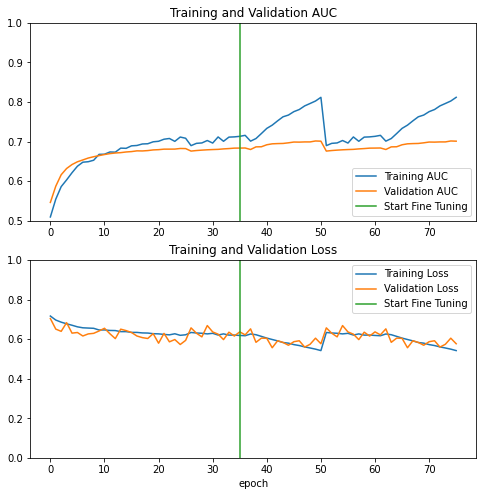

In [28]:
auc = history.history['auc']
val_auc = history.history['val_auc']

loss = history.history['loss']
val_loss = history.history['val_loss']

auc += history1.history['auc']
val_auc += history1.history['val_auc']

loss += history1.history['loss']
val_loss += history1.history['val_loss']

auc += history2.history['auc']
val_auc += history2.history['val_auc']

loss += history2.history['loss']
val_loss += history2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.ylim([0.5, 1])
plt.plot([history1.epoch[-1],history1.epoch[-1]],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation AUC')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([history1.epoch[-1],history1.epoch[-1]],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# **Reload saved model**

In [ ]:
#Only run this cell if you want to reload model run previously.
model_folder = '/content/drive/My Drive/Colab Notebooks/models/'

custom_objects = {"NPV": NPV, "Specificity": Specificity}
with keras.utils.custom_object_scope(custom_objects):
    model = tf.keras.models.load_model(model_folder + "Covid_Model_MobileNetV2_2.h5")

# **Apply model to test dataset.**

In [22]:
# Import Test dataframe
df_test = pd.read_csv(os.path.join(folder, 'df_test.csv'), index_col=0)

#Rescale images in the same way as for train and validation sets
test_data = datagen.flow_from_dataframe(df_test, x_col = "image_file", y_col = "status", 
                                           target_size = (288,432), 
                                           class_mode = "binary", batch_size = batch_size, 
                                           shuffle = False, validate_filenames = True)

#Create dataset
test_dataset = tf.data.Dataset.from_generator(
    lambda: test_data, 
    output_types = (tf.float32 , tf.float32), 
    output_shapes = ([None , 288 , 432 , 3] , [None , ])
)

#Assert cardinality so the length can be used.
test_dataset = test_dataset.apply(tf.data.experimental.assert_cardinality(df_test.shape[0]))

Found 1000 validated image filenames belonging to 2 classes.


In [26]:
_,TP,FP,FN,TN, Spec, npv, Recall, AUC = model.evaluate(test_dataset, steps = df_test.shape[0]//batch_size)
print('Confusion Matrix: ', TP, FP, FN, TN)
print('Test NPV: %.4f' % npv)
print('Test Specificity: %.4f' % Spec)
print('Test Sensitivity: %.4f' % Recall)
print('Test ROC-AUC: %.4f' % AUC)

10/10 [==============================] - 5s 531ms/step - loss: 0.6114 - TP: 583.0000 - FP: 45.0000 - FN: 303.0000 - TN: 69.0000 - NPV: 0.1855 - specificity: 0.6053 - recall: 0.6580 - auc: 0.6871
Confusion Matrix:  583.0 45.0 303.0 69.0
Test NPV: 0.6053
Test Specificity: 0.1855
Test Sensitivity: 0.6580
Test ROC-AUC: 0.6871
